In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import roc_curve, precision_recall_curve, auc

model_list = ['map', 'ensemble','bbb', 'dropout', 'bbh', 'mnf']
model_name = ['L2', 'DE', 'BBB', 'DP','BBH','MNF']
experiment_list = ['_l2', '', '_analytical', '_l2','_klapprox','_analytical'] 

def empCDF(entropy,n=10): 
    x = np.linspace(0,np.log(n), 1000)
    y = np.zeros_like(x)
    for i, val in enumerate(x):
        y[i] = np.mean(entropy<=val)
    return entropy, x,y

def plot_adv(results, model_name, num_classes):    
    plt.figure(figsize=(10,4))
    
    num=20
    colors = ['purple', 'green', 'cyan', 'blue', 'olive', 'black', 'orange', 'red']

    ax1 = plt.subplot(1, 1, 1)
    for name, color in  zip(model_name, colors):
        result = results[name]
        adv_df = result['adv_df']
        plt.plot(adv_df.eps[0:6], adv_df.acc[0:6], '-o', label = name, color = color)
    plt.legend(prop = {'size':num}, loc="upper center",bbox_to_anchor=(0,1,1,1),  ncol = len(model_name),frameon=False)
#     plt.legend(prop = {'size':num}, loc="upper center",bbox_to_anchor=(0.7,0,1,1))
    plt.xticks(fontsize=num)
    plt.yticks(fontsize=num)
    plt.grid(True)
    plt.xlim(-0.02, 1.02)
    plt.ylim(0, 1.02)
    plt.xlabel('perturbation', fontsize=num)
    plt.ylabel('Accuracy', fontsize=num)

    plt.xticks(fontsize=num)
    plt.yticks(fontsize=num)
    ax2 = ax1.twinx() 

    for name, color in  zip(model_name, colors):
        result = results[name]
        adv_df = result['adv_df']
        plt.plot(adv_df.eps[0:6], adv_df.ent[0:6]/np.log(num_classes), '-.o', label = name, color = color)

    plt.xticks(fontsize=num)
    plt.yticks(fontsize=num)
    plt.grid(True)
    plt.xlim(-0.002, 0.502)
    plt.ylim(0, 1.02)
    plt.xlabel('', fontsize=num)
    plt.ylabel('Entropy', fontsize=num)

    plt.xticks(fontsize=num)
    plt.yticks(fontsize=num)

    
def plot_auroc(results, model_name, num_classes):  
    plt.figure()
    for name in  model_name:
        result = results[name]
        normal = result['test_entropy']
        ood_key = 'not_mnist_entropy' if 'not_mnist_entropy' in result.keys() else 'outlier_entropy'
        anormal = result[ood_key] 

        truth = np.zeros((normal.shape[0]+anormal.shape[0],))
        truth[normal.shape[0]:]=1

        total_entropy = np.concatenate((normal, anormal), axis=0)/ np.log(num_classes)

        fpr, tpr, roc_thresholds = roc_curve(truth, total_entropy)
        roc_auc = auc(fpr, tpr)
        print(name, '\t', normal.shape,anormal.shape, '\tauroc', roc_auc )
        plt.plot(fpr,tpr, label= name)
    plt.legend(prop = {'size':15})
    plt.title('AUROC')

def plot_ood_entropy(results, model_name, num_classes):  
    plt.figure()
    for name in  model_name:
        result = results[name]
        ood_key = 'not_mnist_entropy' if 'not_mnist_entropy' in result.keys() else 'outlier_entropy'
        anormal = result[ood_key]
        _,x,y=empCDF(anormal, num_classes)
        plt.plot(x/np.log(num_classes),y,label=name)
    plt.legend(prop = {'size':15})
    plt.title('ood entropy')    

def plot_in_entropy(results, model_name, num_classes):  
    plt.figure()
    for name in  model_name:
        result = results[name]
        normal = result['test_entropy']
        _,x,y=empCDF(normal, num_classes)
        plt.plot(x/np.log(num_classes),y,label=name)
    plt.legend(prop = {'size':15})
    plt.title('in entropy') 
    
    
    
def plot_in_out_entropy(results, model_name, num_classes):
    plt.figure(figsize=(13,4))

    plt.subplot(1, 2, 1)
    for name in  model_name:
        result = results[name]
        normal = result['test_entropy']
        _,x1,y1=empCDF(normal, num_classes)
        plt.plot(x1/np.log(num_classes),y1,label=name)
    plt.legend(prop = {'size':15})
    plt.title('succ')
    plt.xlim(-0.02, 1.02)
    plt.ylim(0, 1.02)

    plt.subplot(1, 2, 2)
    for name in  model_name:
        result = results[name]
        ood_key = 'not_mnist_entropy' if 'not_mnist_entropy' in result.keys() else 'outlier_entropy'
        anormal = result[ood_key]
        _,x2,y2=empCDF(anormal, num_classes)
        plt.plot(x2/np.log(num_classes),y2,label=name)
    plt.legend(prop = {'size':15})
    plt.title('fail')
    plt.xlim(-0.02, 1.02)
    plt.ylim(0, 1.02)


    plt.figure(figsize=(10,10))
    i=1
    for name in  model_name:
        result = results[name]
        
        normal = result['test_entropy']
        
        ood_key = 'not_mnist_entropy' if 'not_mnist_entropy' in result.keys() else 'outlier_entropy'
        anormal = result[ood_key]

        _,x1,y1=empCDF(normal, num_classes)
        _,x2,y2=empCDF(anormal, num_classes)

        plt.subplot(3, 3, i)
        plt.plot(x1/np.log(num_classes),y1,label=name + ' ID')
        plt.plot(x2/np.log(num_classes),y2,label=name + ' OOD')
        plt.legend(prop = {'size':15})
        plt.xlim(-0.02, 1.02)
        plt.ylim(0, 1.02)
    
        i +=1
    
def plot_succ_fail(results, model_name, num_classes):
    plt.figure(figsize=(13,4))

    plt.subplot(1, 2, 1)
    for name in  model_name:
        result = results[name]
        succ = result['succ_entropy']
        _,x1,y1=empCDF(succ, num_classes)
        plt.plot(x1/np.log(num_classes),y1,label=name)
    plt.legend(prop = {'size':15})
    plt.title('succ')
    plt.xlim(-0.02, 1.02)
    plt.ylim(0, 1.02)

    plt.subplot(1, 2, 2)
    for name in  model_name:
        result = results[name]
        fail =  result['fail_entropy']
        _,x2,y2=empCDF(fail, num_classes)
        plt.plot(x2/np.log(num_classes),y2,label=name)
    plt.legend(prop = {'size':15})
    plt.title('fail')
    plt.xlim(-0.02, 1.02)
    plt.ylim(0, 1.02)


    plt.figure(figsize=(10,10))
    i=1
    for name in  model_name:
        result = results[name]
        
        succ = result['succ_entropy']
        fail =  result['fail_entropy']
        _,x1,y1=empCDF(succ, num_classes)
        _,x2,y2=empCDF(fail, num_classes)

        plt.subplot(3, 3, i)
        plt.plot(x1/np.log(num_classes),y1,label=name + ' succ')
        plt.plot(x2/np.log(num_classes),y2,label=name + ' fail')
        plt.legend(prop = {'size':15})
        plt.xlim(-0.02, 1.02)
        plt.ylim(0, 1.02)
    
        i +=1

def draw_boxplot(data, offset,edge_color, fill_color):
    pos = np.arange(data.shape[1])+offset 
    bp = ax.boxplot(data, positions= pos, widths=0.3, patch_artist=True, manage_ticks=False,sym = '' )
    for element in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)


def plot_boxplot(results, model_name, num_classes):        
    data  = np.array([results[name]['test_entropy']  for name in  model_name ] ).T
    df1 = data/np.log(num_classes)
    
    data  = np.array([results[name]['not_mnist_entropy'] if 'not_mnist_entropy' in results[name] else results[name]['outlier_entropy'] for name in  model_name ] ).T
    df2 = data/np.log(num_classes)


    fig, ax = plt.subplots(figsize=(9,3))
    # fig= plt.figure()
    draw_boxplot(df1, -0.2, "blue", "white")
    draw_boxplot(df2, +0.2,"red", "white")
    plt.xticks(range(len(model_name)), model_name)

    hB, = plt.plot([1,1],'b-')
    hR, = plt.plot([1,1],'r-')
    plt.legend((hB, hR),('ID', 'OOD'), loc = 'upper left')
    hB.set_visible(False)
    hR.set_visible(False)

    plt.show()
    return

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)


# CIFAR

In [20]:
model_list = ['map', 'ensemble','bbb', 'dropout', 'bbh', 'mnf']
model_name = ['L2', 'DE', 'BBB', 'DP','BBH','MNF']
experiment_list = ['_l2', '', '_analytical', '_l2','_klapprox','_analytical'] 

In [22]:
num_classes = 5
dataname ='cifar_resnet'

results = {}
for name,i,j in zip(model_name, model_list, experiment_list):
    with open('./BayesByHypernet/{}/{}/resnet20/{}{}/dump.pickle'.format(dataname,i, i, j), 'rb') as file:
        result = pickle.load(file)
        results[name] = result

In [23]:
for name in results.keys():
    print(name, '\t',results[name]['test_acc'])

L2 	 0.8584
DE 	 0.889
BBB 	 0.8462
DP 	 0.7912
BBH 	 0.8766
MNF 	 0.8538


In [35]:
# with open('./results/edl_cifar5_810_resnet_result.pt', 'rb') as file:
#     results['ENN'] = pickle.load(file)
    
# with open('./results/gen_cifar5_810_resnet_result.pt', 'rb') as file:
#     results['GEN'] = pickle.load(file)

with open('./wgan-enn/saved_results/resnet20_in_0_out_0.1_time_2020-08-03_21-23-03/record.pt', 'rb') as file:
     results['WENN'] = pickle.load(file)

In [36]:
for key in results['WENN']:
    if type(results['WENN'][key])== list:
        results['WENN'][key] = np.array(results['WENN'][key])

In [37]:
results.keys()

dict_keys(['L2', 'DE', 'BBB', 'DP', 'BBH', 'MNF', 'WENN'])

In [38]:
i=0
for name in results.keys():
    i += results[name]['test_acc']
    print(name, '\t',results[name]['test_acc'])
print(i/9)

L2 	 0.8584
DE 	 0.889
BBB 	 0.8462
DP 	 0.7912
BBH 	 0.8766
MNF 	 0.8538


KeyError: 'test_acc'

(-0.02, 1.02)

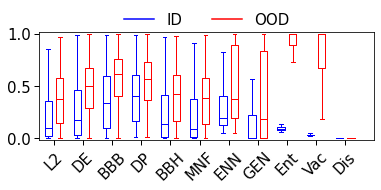

In [ ]:
model_name = results.keys()
df1  = [results[name]['test_entropy']/np.log(num_classes)  for name in  model_name ] +[results['WENN']['in_vac']] + [results['WENN']['in_dis']]
df2  = [results[name]['not_mnist_entropy']/np.log(num_classes) 
                 if 'not_mnist_entropy' in results[name] 
                 else results[name]['outlier_entropy'] /np.log(num_classes)
                 for name in  model_name ]  + [results['WENN']['ood_vac']]  + [results['WENN']['ood_disn']]

ticks = list(model_name) #+ ['WENN vac'] #+ ['WENN dis']
# ticks = ['L2', 'DE', 'BBB', 'DP', 'BBH', 'MNF', 'ENN', 'GEN', 'Ent', 'Vac']
ticks = ['L2', 'DE', 'BBB', 'DP', 'BBH', 'MNF', 'ENN', 'GEN', 'Ent', 'Vac', 'Dis']
# ticks = ['L2', 'DE', 'BBB', 'DP', 'BBH', 'MNF', 'ENN', 'GEN', '  WENN']
num = 15

# plt.figure(figsize=(8,3))

plt.figure(figsize=(6,2))

plt.tick_params(which='major',width=1)
plt.tick_params(which='major',length=5)

bpl = plt.boxplot(df1, positions=np.array(range(len(df1)))*2.0-0.4, sym='', widths=0.5)
bpr = plt.boxplot(df2, positions=np.array(range(len(df2)))*2.0+0.4, sym='', widths=0.5)


# bpl = plt.boxplot(df1, positions=np.array(range(len(df1)))*2.0-0.4, sym='', widths=0.5)
# bpr = plt.boxplot(df2, positions=np.array(range(len(df2)))*2.0+0.4, sym='', widths=0.5)
set_box_color(bpl, 'blue') 
set_box_color(bpr, 'red')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='blue', label='ID')
plt.plot([], c='red', label='OOD')
# plt.legend(loc='center right',prop = {'size':num})
plt.legend(prop = {'size':num}, loc="upper center",bbox_to_anchor=(0,0.2,1,1.1),  ncol = len(model_name),frameon=False)
# plt.grid(True)
plt.xticks(fontsize=num, rotation=45)
plt.yticks([0.0, 0.5, 1.0],fontsize=num)
plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-1, len(ticks)*2)
plt.ylim(-0.02, 1.02)
# plt.tight_layout()

/home/yibo/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/yibo/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(-0.02, 1.02)

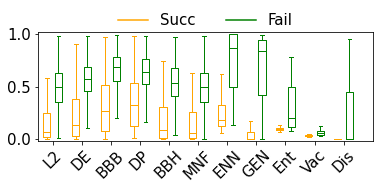

In [ ]:
model_name = results.keys()
df1  = [results[name]['succ_entropy']/np.log(num_classes)  for name in  model_name ] + [results['WENN']['succ_vac']] + [results['WENN']['succ_dis']]
df2  = [results[name]['fail_entropy']/np.log(num_classes)  for name in  model_name ] + [results['WENN']['fail_vac']] + [results['WENN']['fail_dis']]

# ticks = list(model_name) + ['vac'] #+ ['WENN dis']
ticks = ['L2', 'DE', 'BBB', 'DP', 'BBH', 'MNF', 'ENN', 'GEN', 'Ent', 'Vac', 'Dis']

num = 15

plt.figure(figsize=(6,2))

bpl = plt.boxplot(df1, positions=np.array(range(len(df1)))*2.0-0.4, sym='', widths=0.5)
bpr = plt.boxplot(df2, positions=np.array(range(len(df2)))*2.0+0.4, sym='', widths=0.5)
set_box_color(bpl, 'orange') 
set_box_color(bpr, 'green')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='orange', label='Succ')
plt.plot([], c='green', label='Fail')
# plt.legend(loc='upper right',prop = {'size':num})

plt.legend(prop = {'size':num}, loc="upper center",bbox_to_anchor=(0,0.2,1,1.1),  ncol = len(model_name),frameon=False)
# plt.grid(True)
plt.xticks(fontsize=num, rotation=45)
plt.yticks([0.0, 0.5, 1.0],fontsize=num)
plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-1, len(ticks)*2)
plt.ylim(-0.02, 1.02)
# plt.tight_layout()

L2 	 (5000,) (5000,) 	auroc 0.7155528800000001
DE 	 (5000,) (5000,) 	auroc 0.7356816
BBB 	 (5000,) (5000,) 	auroc 0.7117274
DP 	 (5000,) (5000,) 	auroc 0.65806264
BBH 	 (5000,) (5000,) 	auroc 0.7007086
MNF 	 (5000,) (5000,) 	auroc 0.7093432399999999
ENN 	 (5000,) (5000,) 	auroc 0.6634765400000001
GEN 	 (5000,) (5000,) 	auroc 0.6639858
WENN 	 (5000,) (5000,) 	auroc 0.99760452


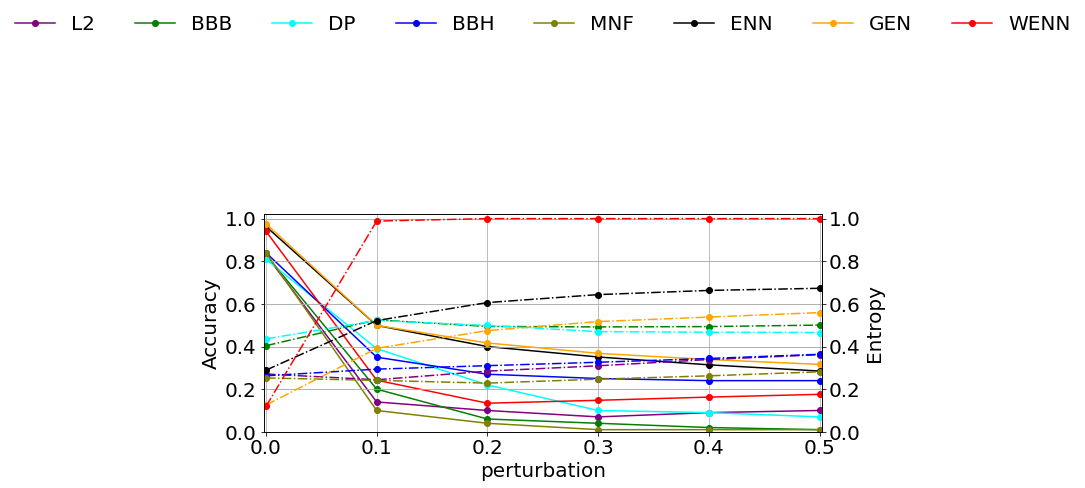

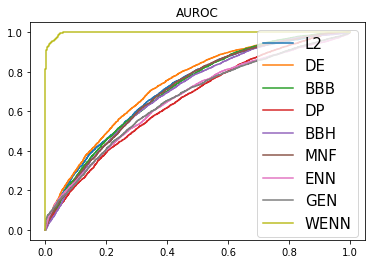

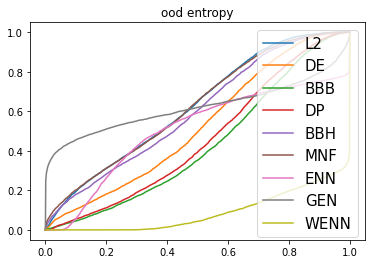

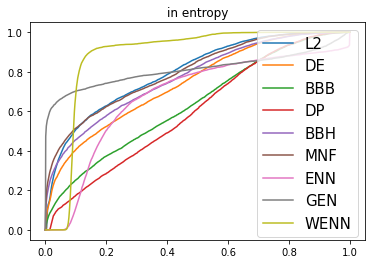

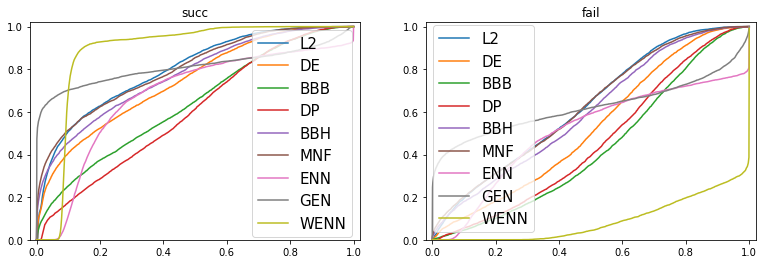

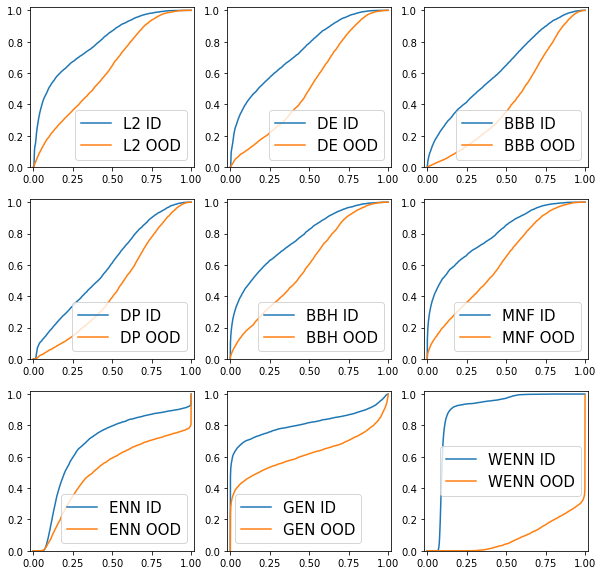

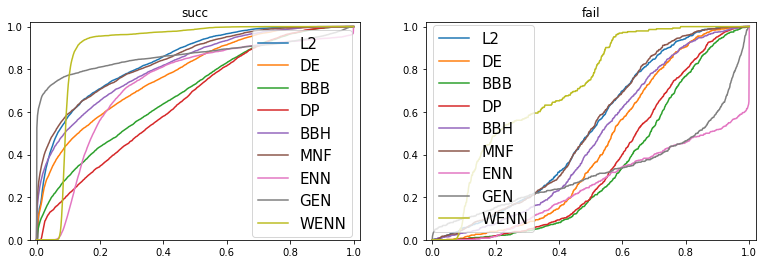

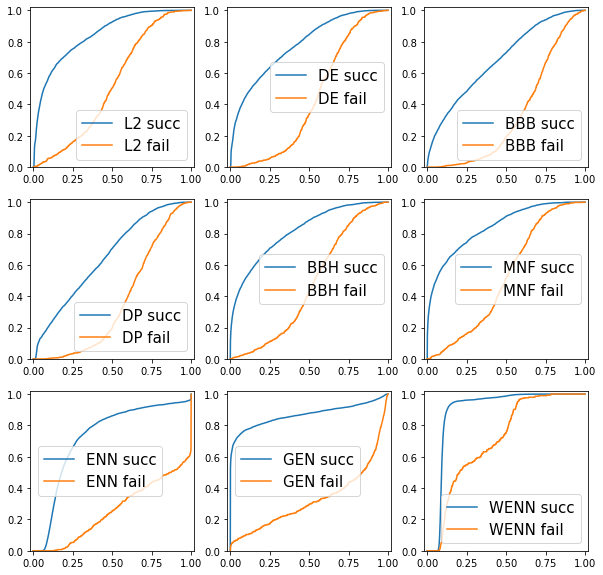

In [ ]:
plot_adv(results,['L2', 'BBB', 'DP', 'BBH', 'MNF', 'ENN', 'GEN','WENN'], 5) 
plot_auroc(results, results.keys(), num_classes)
plot_ood_entropy(results, results.keys(), num_classes)
plot_in_entropy(results, results.keys(), num_classes)
plot_in_out_entropy(results, results.keys(), num_classes)
plot_succ_fail(results, results.keys() , num_classes)

**The change of Wasserstein distance**

In [28]:
with open('./wgan-enn/saved_results/resnet20_in_0_out_0.1_time_2020-08-01_23-47-58/record.pt', 'rb') as file:
     record = pickle.load(file)

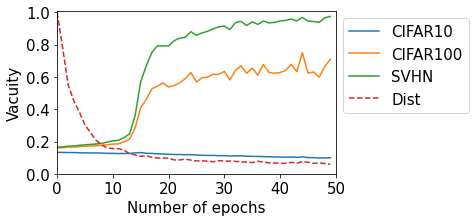

In [30]:
record['df_train_avg']['dist']
record['df_test_avg']['in_vac']
record['df_test_avg']
record['df_ood_avg_list']['CIFAR100']['ood_vac']
record['df_ood_avg_list']['SVHN']['ood_vac']

   
title= ''

plt.figure(figsize=(5,3))

plt.title(title)

# plt.plot(record['df_train_avg']['train_in_vac'], label = 'Train ID')
plt.plot(record['df_test_avg']['in_vac'], label = 'CIFAR10')

plt.plot(record['df_ood_avg_list']['CIFAR100']['ood_vac'], label = 'CIFAR100')
plt.plot(record['df_ood_avg_list']['SVHN']['ood_vac'], label = 'SVHN')

dist = record['df_train_avg']['dist']

plt.plot(dist/dist.max(),'--', label = 'Dist')

plt.xlim(-0.02,50.02)
plt.ylim(0, 1.01)
plt.legend(prop = {'size':15},bbox_to_anchor=(1,1))
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Vacuity', fontsize=15)

plt.xticks(fontsize=15);
plt.yticks(fontsize=15);